In [14]:
from PIL import Image
import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from skimage.transform import resize

import torch

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load images

In [2]:
resize_image_path_synthia = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\image"
resize_label_path_synthia = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\label-rgb"

cityscapes_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\original_cityscapes_inputs"

In [3]:
# get relative path for both datasets, because global path is not allowed ("Not allowed to load local resource")
start = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image"
relative_path_cityscapes = os.path.relpath(cityscapes_path, start)
relative_path_synthia = os.path.relpath(resize_image_path_synthia, start)

In [4]:
# Cityscapes
# import the pickle 
cityscapes_100 = []
cityscapes_path_100 = []

cityscapes_names= os.listdir(cityscapes_path)
cityscapes_names_100 = random.choices(cityscapes_names, k=100)
for name in cityscapes_names_100:
    image = Image.open(cityscapes_path+"\\"+name).convert("RGB")
    
    cityscapes_100.append(np.array(image))
    cityscapes_path_100.append(relative_path_cityscapes+"\\"+name)

cityscapes_100 = np.array(cityscapes_100)
cityscapes_path_100 = np.array(cityscapes_path_100)

In [5]:
# synthia

synthia_100 = []
synthia_path_100 =[]

synthia_names = os.listdir(resize_image_path_synthia)
# randomly select 100 images to load in to numpy array
synthia_names_100 = random.choices(synthia_names, k=100)
for name in synthia_names_100:
#     print(name)
#     print(resize_image_path_synthia)
#     print(resize_image_path_synthia+"\\"+name)
    image = Image.open(resize_image_path_synthia+"\\"+name).convert("RGB")
    
    synthia_100.append(np.array(image))
    synthia_path_100.append(relative_path_synthia+"\\"+name)

synthia_100 = np.array(synthia_100)
synthia_path_100 = np.array(synthia_path_100)

In [6]:
# concatenate the images and the paths from two different dataset
combined_images = np.concatenate((cityscapes_100,synthia_100),axis=0)
# combined_images = np.reshape(combined_embedding,(len(combined_embedding), 256*256*3))

combined_paths = np.concatenate((cityscapes_path_100,synthia_path_100),axis=0)

In [8]:
combined_images.shape

(200, 256, 256, 3)

# Load model

In [16]:
cd D:\zsh\graduation\ViTs-vs-CNNs

D:\zsh\graduation\ViTs-vs-CNNs


In [17]:
import torch
import torch.nn as nn
import global_val

from models.ghost_bn import GhostBN2D_ADV
from models.advresnet_gbn_gelu import Affine
import models.advresnet_gbn_gelu as advres
from main_adv_res import EightBN

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = advres.__dict__["resnet50"](norm_layer = EightBN)
weights_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\models\\advres50_gelu.pth"
weight_dict = torch.load(weights_path,map_location=device)["model"]

In [21]:
model.load_state_dict(weight_dict)

<All keys matched successfully>

In [23]:
# print(model)

# Generate embedding

In [12]:
def get_representation_for_image(image,label):
    # resize the image and transform it to tensor # [256,256,3] -> [224,224,3] 
    resized_image = resize(image, (224, 224,3))
    resized_image_tensor = torch.from_numpy(resized_image)
    resized_image_tensor = torch.permute(resized_image_tensor, (2, 0, 1))
    resized_image_tensor = resized_image_tensor[None,:] # [3,224,224] -> [1,3,224,224] (because model takes 4D input)
    
    # dictionary for the activations
    activations = {}

    def get_activations(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # use the output of (avgpool) layer because it is the same as the input of last layer
    h = model.avgpool.register_forward_hook(get_activations("input_last_layer"))

    model.eval()
    model.sing=True
    model.training=False
    out = model(resized_image_tensor.float(),label)
    
    # remove the hook
    h.remove()

    first_part_embedding = torch.flatten(activations["input_last_layer"][0])
    # the second part of the embedding is size of each class
    second_part_embedding=[]
    for i in range(6):
        class_size = np.count_nonzero(label == i)
        second_part_embedding.append(class_size)
    embedding = np.concatenate((first_part_embedding.numpy(),np.array(second_part_embedding)),axis = 0)
    
    return embedding

In [25]:
embedding_list = []
for i, image in enumerate(combined_images): # i is not used, could remove the enumerate
    embedding = get_representation_for_image(image,"__") # y_label is never used, so just use replacement
    embedding_list.append(embedding)

In [26]:
embedding_arr = np.array(embedding_list)

In [27]:
embedding_arr.shape

(200, 2054)

In [28]:
# back to where the jupyter notebook is in
cd D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\jupyter

D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\jupyter


PCA(50)->TSNE

In [45]:
pca_50 = PCA(n_components=50)
pca_embedding = pca_50.fit_transform(embedding_arr)
print(np.sum(pca_50.explained_variance_ratio_))
# pca = PCA(n_components=2)
tsne = TSNE()
tsne_embedding = tsne.fit_transform(pca_embedding)
# tsne_embedding = tsne.fit_transform(embedding_arr)

df_tsne = pd.DataFrame(tsne_embedding,columns=["tsne_1","tsne_2"])

df_tsne["dataset"] =np.nan
df_tsne["path"] = combined_paths

df_tsne["dataset"].iloc[:100] = "Cityscapes"
df_tsne["dataset"].iloc[100:] = "Synthia"

0.8674479314149676


d:\zsh\graduation\grad_env_take_2\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [46]:
df_tsne.head()

,tsne_1,tsne_2,dataset,path
0,-2.221869,4.099285,Cityscapes,dataset\original_cityscapes_inputs\191.jpeg
1,-10.937391,0.514338,Cityscapes,dataset\original_cityscapes_inputs\31.jpeg
2,-11.663597,7.924657,Cityscapes,dataset\original_cityscapes_inputs\171.jpeg
3,9.959833,-6.416883,Cityscapes,dataset\original_cityscapes_inputs\9.jpeg
4,-8.518798,-0.133276,Cityscapes,dataset\original_cityscapes_inputs\340.jpeg


<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

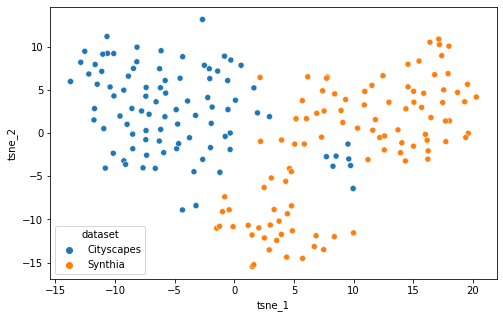

In [47]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="dataset", # see if this need to be changed
#     palette=sns.color_palette("hls", 2), # palette corresponds to hue
    data=df_tsne # df_tsne_1 or df_tsne_2
)

In [48]:
# save
df_tsne.to_csv("df_input_discrete_embedding_by_classfier.csv",index=False)